In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial as scs
import scipy.integrate
from scipy.interpolate import CubicSpline
import scipy.spatial.transform as sst
import functools

In [3]:
class CUBE(object):
  def __init__(self, fname):
    f = open(fname, 'r')
    for i in range(2): f.readline() # echo comment
    tkns = f.readline().split() # number of atoms included in the file followed by the position of the origin of the volumetric data
    self.natoms = int(tkns[0])
    self.origin = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NX = int(tkns[0])
    self.X = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NY = int(tkns[0])
    self.Y = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NZ = int(tkns[0])
    self.Z = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    self.atoms = []
    for i in range(self.natoms):
      tkns = f.readline().split()
      self.atoms.append([tkns[0], tkns[2], tkns[3], tkns[4]])
    self.data = np.zeros((self.NX,self.NY,self.NZ))
    i=0
    for s in f:
      for v in s.split():
        self.data[i//(self.NY*self.NZ), (i//self.NZ)%self.NY, i%self.NZ] = float(v)
        i+=1
    if i != self.NX*self.NY*self.NZ: raise NameError("FSCK!")


In [99]:
@functools.lru_cache(32)
def read_qs(folder):
    cube = CUBE('data-density/box-20/%s/DENSITY.cube' % folder)
    #cube = CUBE('data/CO-2/box-12/%s/DENSITY.cube' % folder)
    return cube.data

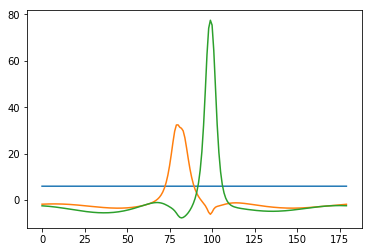

In [100]:
def get_deriv(loc, site):
    if loc != '1.0':
        up = read_qs('lval-%s00000-%s-up' %(loc, site))
    else:
        up = read_qs('lval-1.000000')
    if loc != '0.0':
        dn = read_qs('lval-%s00000-%s-dn'% (loc, site))
    else:
        dn = read_qs('lval-0.000000')
    if loc in '0.0 1.0'.split():
        delta = 0.005
    else:
        delta = 0.01
    return (up-dn)/delta    

def get_total(site):
    lvals = []
    ds = []
    for mval in '0.0 0.2 0.4 0.6 0.8 1.0'.split():
        tmp = get_deriv(mval, site)
        ds.append(tmp.ravel())
        lvals.append(float(mval))
    #total = scipy.integrate.simps(ds, lvals, axis=0)
    total = np.trapz(ds, lvals, axis=0)
    return total.reshape(tmp.shape)

tr = read_qs('lval-0.000000')
tf = read_qs('lval-1.000000')
plt.plot(tr.sum(axis=1).sum(axis=1))
tc= get_total('C')
plt.plot(tc.sum(axis=1).sum(axis=1))
to= get_total('O')

plt.plot(to.sum(axis=1).sum(axis=1))

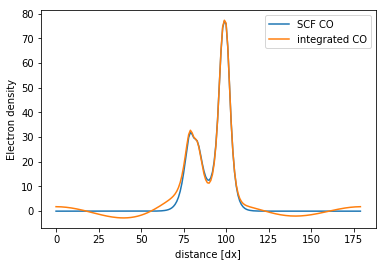

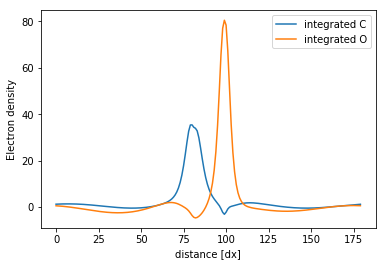

In [101]:
plt.ylabel('Electron density')
plt.xlabel('distance [dx]')

plt.plot(tf.sum(axis=1).sum(axis=1), label='SCF CO')
plt.plot((tr+tc+to).sum(axis=1).sum(axis=1), label='integrated CO')
plt.legend()
plt.show()
plt.ylabel('Electron density')
plt.xlabel('distance [dx]')
plt.plot((tc+tr/2).sum(axis=1).sum(axis=1), label='integrated C')
plt.plot((to+tr/2).sum(axis=1).sum(axis=1), label='integrated O')
plt.legend()

In [102]:
import h5py

In [125]:
f = h5py.File('density-comparison/CO/output-h.h5', 'r')

In [126]:
f.keys()

<KeysViewHDF5 ['atom_00000', 'atom_00001', 'c6s', 'cartesian_multipoles', 'charges', 'populations', 'pseudo_populations', 'pure_multipoles', 'radial_moments', 'spin_charges', 'volume_ratios', 'volumes']>

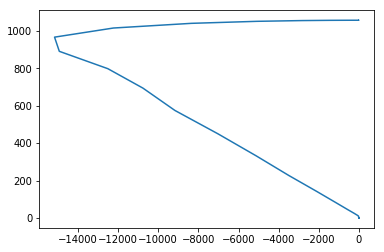

In [137]:
xs = np.array(f['atom_00000']['density_decomposition']['spline_00000']['d'])
ys = np.array(f['atom_00000']['density_decomposition']['spline_00000']['y'])
plt.plot(xs, ys)

In [136]:
f['atom_00000']['density_decomposition']['spline_00000'].keys()

<KeysViewHDF5 ['d', 'y']>

In [139]:
tcube = CUBE('data-density/box-20/lval-1.000000/DENSITY.cube')

(14, 22)

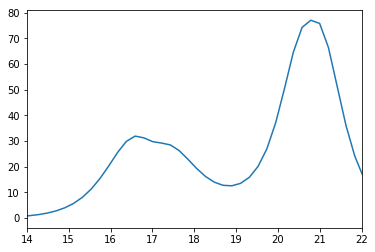

In [147]:
xs = np.arange(0, tcube.data.shape[0])*tcube.X[0]
plt.plot(xs, tcube.data.sum(axis=1).sum(axis=1))
plt.xlim(14, 22)

In [153]:
print (repr(xs))

array([ 0.     ,  0.20997,  0.41994,  0.62991,  0.83988,  1.04985,
        1.25982,  1.46979,  1.67976,  1.88973,  2.0997 ,  2.30967,
        2.51964,  2.72961,  2.93958,  3.14955,  3.35952,  3.56949,
        3.77946,  3.98943,  4.1994 ,  4.40937,  4.61934,  4.82931,
        5.03928,  5.24925,  5.45922,  5.66919,  5.87916,  6.08913,
        6.2991 ,  6.50907,  6.71904,  6.92901,  7.13898,  7.34895,
        7.55892,  7.76889,  7.97886,  8.18883,  8.3988 ,  8.60877,
        8.81874,  9.02871,  9.23868,  9.44865,  9.65862,  9.86859,
       10.07856, 10.28853, 10.4985 , 10.70847, 10.91844, 11.12841,
       11.33838, 11.54835, 11.75832, 11.96829, 12.17826, 12.38823,
       12.5982 , 12.80817, 13.01814, 13.22811, 13.43808, 13.64805,
       13.85802, 14.06799, 14.27796, 14.48793, 14.6979 , 14.90787,
       15.11784, 15.32781, 15.53778, 15.74775, 15.95772, 16.16769,
       16.37766, 16.58763, 16.7976 , 17.00757, 17.21754, 17.42751,
       17.63748, 17.84745, 18.05742, 18.26739, 18.47736, 18.68